<a href="https://colab.research.google.com/github/pranavarya007/Data-analysis-part1/blob/main/Cryptocurrency_price_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tools used - 


*   NumPy
*   Pandas 
*   Matplotlib
*   Seaborn
*   Keras 
*   Tensorflow



In [ ]:
import pandas as pd

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving data_mv_set.csv to data_mv_set.csv


In [ ]:
dataset = pd.read_csv('data_mv_set.csv')
dataset.head()


,uuid,exchange,ask_price,ask_whole_lot_volume,ask_lot_volume,bid_price,bid_whole_lot_volume,bid_lot_volume,close_price,close_volume,volume_avg_today,volume_avg_24h,trades_today,trades_24h,low_today,low_24h,high_today,high_24h,opening_price,ts
0,9831925d-f9b1-4fde-9d40-34c5dc222a91,kraken,0.000804,289,289,0.000802,150,150,0.000805,150,94508.35523,176635.0497,1087,2278,0.000787,0.000787,0.000855,0.000855,0.000802,25569.50487
1,63644912-c186-4a7c-a0fd-739520c879b6,kraken,0.000804,334,334,0.000802,150,150,0.000805,150,103094.91810,176635.0497,1196,2278,0.000787,0.000787,0.000855,0.000855,0.000802,25569.50487
2,8150086e-98d8-4dd3-91fa-111923a6f78c,kraken,0.000804,289,289,0.000802,150,150,0.000805,150,103094.95470,176635.0497,1198,2278,0.000787,0.000787,0.000855,0.000855,0.000802,25569.50487
3,6df11107-1be2-4e31-97a6-d20e80431b14,kraken,0.000804,134,134,0.000802,150,150,0.000805,150,103249.37390,176635.0497,1199,2278,0.000787,0.000787,0.000855,0.000855,0.000802,25569.50487
4,2d2358d9-dec6-49be-b309-33db96b75eaa,kraken,0.000804,134,134,0.000802,150,150,0.000805,150,103279.59390,176635.0497,1200,2278,0.000787,0.000787,0.000855,0.000855,0.000802,25569.50487


## Data Pre Processing 

First, we start by importing all of the required packages, loading the dataset and removing the rows we are not interested in using.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation
from keras.models import load_model

In [ ]:
dataset = pd.read_csv('data_mv_set.csv')
del dataset['uuid']
del dataset['exchange']
del dataset['volume_avg_today']
del dataset['volume_avg_24h']
del dataset['trades_today']
del dataset['trades_24h']
del dataset['low_today']
del dataset['low_24h']
del dataset['high_today']
del dataset['high_24h']
del dataset['opening_price']

We split the dataset up into a training and test set, and standardise its features. Standardisation is good practice as it reduces overfitting in cases where variance for some features may be higher than others.

In [ ]:
# We want 80% of the data to be used for training, and 20% for testing
n_train_rows = int(dataset.shape[0]*.8)-1

# Split into train and test sets but keep all 9 columns
train = dataset.iloc[:n_train_rows, :]
test = dataset.iloc[n_train_rows:, :]

# The total rows of the two datasets should equal the total amount of rows in your CSV
print(train.shape)
print(test.shape)

(26638, 9)
(6661, 9)


In [ ]:
# Normalise features
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(train.values)
test_set_scaled = sc.fit_transform(test.values)

The LSTM model requires us to organise the data in blocks. Our data is grouped at one-minute intervals and we’ll use blocks of 50 minutes to predict the next block.


In [ ]:
steps = 50

In [ ]:
# Prepare the training data
x_train = []
y_train = []

for i in range(steps, training_set_scaled.shape[0]-steps):
    x_train.append(training_set_scaled[i-steps:i, :])
    y_train.append(training_set_scaled[i, :])

x_train, y_train = np.array(x_train), np.array(y_train)
print(x_train.shape)

(26538, 50, 9)


In [ ]:
# Prepare the test data
x_test = []
y_test = []

for i in range(steps, test_set_scaled.shape[0]):
    x_test.append(test_set_scaled[i-steps:i, :])
    y_test.append(test_set_scaled[i, :])

x_test, y_test = np.array(x_test), np.array(y_test)
print(x_test.shape)

(6611, 50, 9)


## The Model 
Now it’s time to train our model. We choose what type of model we want to use; sequential in this case, and we decide our hyper-parameters.
The model we are using is relatively straightforward, containing 5 hidden layers with 50 neurons each, and a dropout in between every one of those hidden layers. We use the mean-squared-error loss function, the Adam optimiser, set the batch size at 32, and go through this network for 10 epochs.


In [ ]:
model = Sequential()

In [ ]:
epochs = 10

model.add(LSTM(units=50, return_sequences = True, input_shape = (x_train.shape[1],9)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=9))
model.compile(loss="mse", optimizer="adam")
model.fit(x_train, y_train, batch_size = 32, epochs = epochs)
model.summary

model.save("multiple_features_"+str(steps)+"_steps_"+str(epochs)+"_epochs.h5")
print("Saved model to disk")

Epoch 1/10
830/830 [==============================] - 84s 93ms/step - loss: 0.0323
Epoch 2/10
830/830 [==============================] - 76s 92ms/step - loss: 0.0256
Epoch 3/10
830/830 [==============================] - 77s 93ms/step - loss: 0.0231
Epoch 4/10
830/830 [==============================] - 77s 92ms/step - loss: 0.0223
Epoch 5/10
830/830 [==============================] - 78s 93ms/step - loss: 0.0221
Epoch 6/10
830/830 [==============================] - 78s 94ms/step - loss: 0.0219
Epoch 7/10
830/830 [==============================] - 77s 93ms/step - loss: 0.0218
Epoch 8/10
830/830 [==============================] - 78s 94ms/step - loss: 0.0217
Epoch 9/10
830/830 [==============================] - 77s 92ms/step - loss: 0.0217
Epoch 10/10
830/830 [==============================] - 77s 93ms/step - loss: 0.0216
Saved model to disk


Now that we have a model that we can use to build predictions we can take a look at how it performs against our test data. The graph below plots the test data (y_test) prediction (y_hat) of both the ask price and bid price. As we can see the predictive values match the training data quite well.

In [ ]:
# Evaluate the model on the test data using `evaluate`
print('\n# Evaluate on test data')
results = model.evaluate(x_test, y_test, batch_size=32)
print('test loss, test acc:', results)


# Evaluate on test data
207/207 [==============================] - 6s 23ms/step - loss: 0.0189
test loss, test acc: 0.018897082656621933


In [ ]:
# Predict values from test data trained using training data
y_hat = model.predict(x_test)
y_hat = sc.inverse_transform(y_hat)


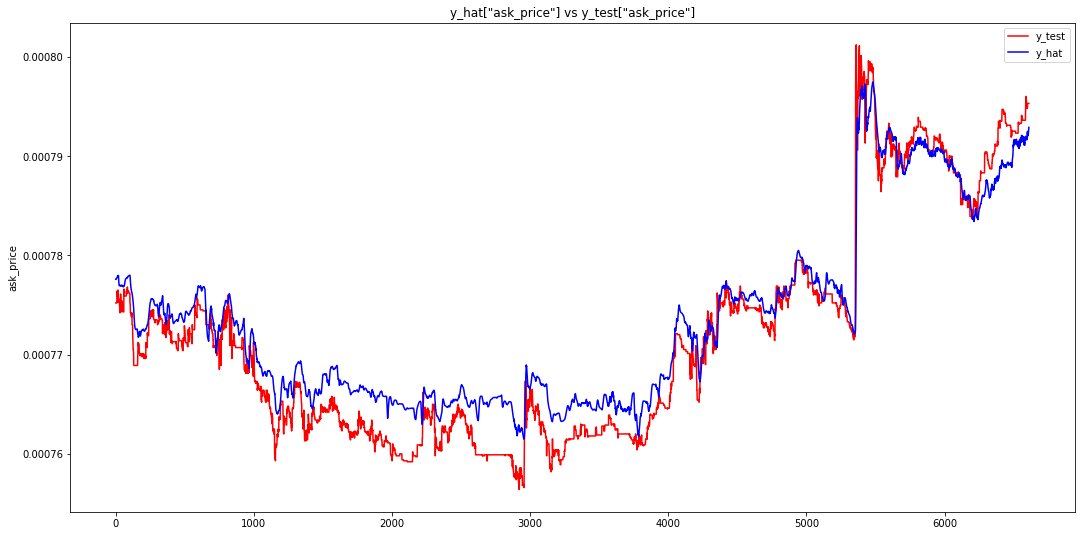

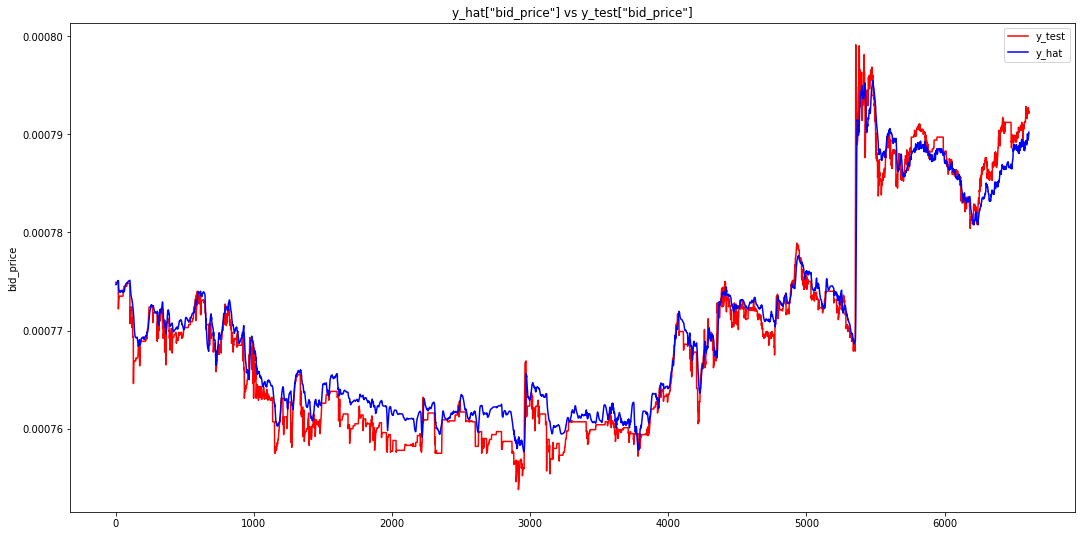

In [ ]:
y_test = test[steps:].reset_index()

# Visualise the ask_price predictions
plt.figure(figsize = (18,9))
plt.plot(y_test['ask_price'], color = 'red', label = 'y_test')
plt.plot(y_hat[:,0], color = 'blue', label = 'y_hat')
plt.title('y_hat["ask_price"] vs y_test["ask_price"]')
plt.ylabel('ask_price')
plt.legend()
plt.show()

# Visualise the bid_price predictions
plt.figure(figsize = (18,9))
plt.plot(y_test['bid_price'], color = 'red', label = 'y_test')
plt.plot(y_hat[:,3], color = 'blue', label = 'y_hat')
plt.title('y_hat["bid_price"] vs y_test["bid_price"]')
plt.ylabel('bid_price')
plt.legend()
plt.show()

The predictive power of these models is definitely impressive, but if you take a closer look at the prediction you’ll see it quite narrowly follows the test data. The prediction appears to closely follow changes in price, but doesn’t often correctly forecast the price at the point at which these movements occur. This isn’t incredibly useful for any trading strategy you may want to use this for.

## Predicting the price
If we wanted to forecast the price 20 minutes from now one option would be to run the model over an immediately recent interval of historical data, concatenating the prediction to the end of our array of historical data, and then feeding that array back into the model — continuing this until we have 20 forecasted blocks of price predictions.

In [ ]:
def moving_test_window_preds(start, n_future_preds):
    
    # Declare variable where we store the prediction made on each window and the moving input window
    prediction = [] 
    moving_input_window = []
    
    # Set the inputs
    inputs = test.reset_index(drop=True).values
    inputs = sc.transform(inputs)

    moving_input_window.append(inputs[start:(start+steps), :])
    moving_input_window = np.array(moving_input_window)
    moving_input_window = np.reshape(moving_input_window, (moving_input_window.shape[0], moving_input_window.shape[1], 9))
    
    # Loop over the amount of future predictions we want to make
    for i in range(n_future_preds):
        
        # Predict the next price based on the moving_input_window
        y_hat = model.predict(moving_input_window)
        
        # Append y_hat to predictions
        prediction.append(y_hat[0,:])
        
        # Reshape y_hat for concatenation with moving test window
        y_hat = y_hat.reshape(1,1,9) 
        
        # Remove first element
        moving_input_window = np.concatenate((moving_input_window[:,1:,:], y_hat),axis=1)

    prediction = sc.inverse_transform(pd.DataFrame(prediction))
    
    return prediction


In [ ]:
n_future_preds = 20
prediction = moving_test_window_preds(0,n_future_preds)

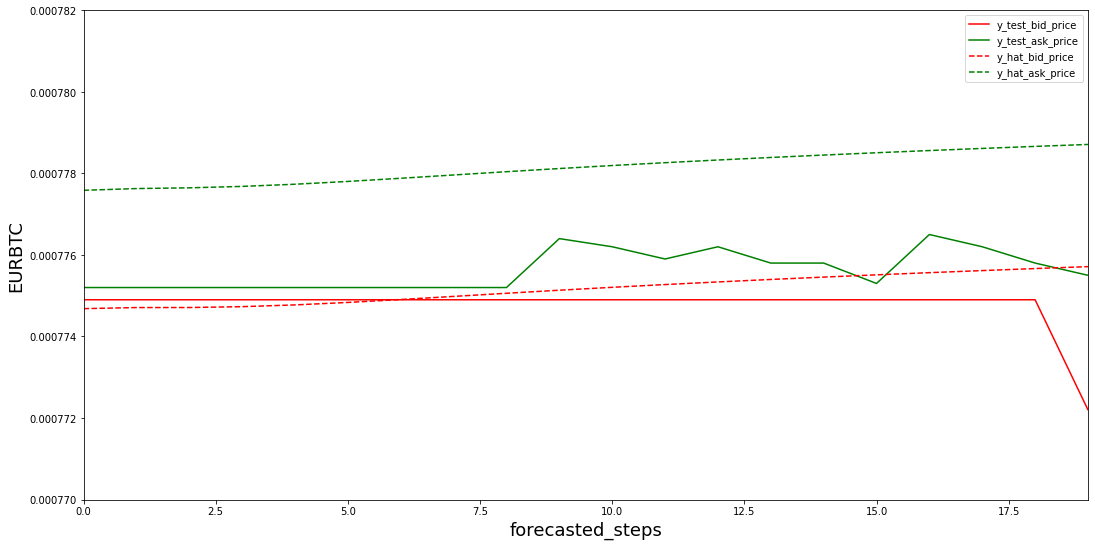

In [ ]:
plt.figure(figsize = (18,9))
plt.plot(y_test["bid_price"], color = 'red', label='y_test_bid_price')
plt.plot(y_test["ask_price"], color = 'green', label='y_test_ask_price')
plt.plot(prediction[:,3], color = 'red', label='y_hat_bid_price', linestyle='--')
plt.plot(prediction[:,0], color = 'green', label='y_hat_ask_price', linestyle='--')
plt.gca().set_xlim(0,prediction.shape[0]-1)
plt.gca().set_ylim(0.00077,0.000782)
plt.xlabel('forecasted_steps', fontsize=18)
plt.ylabel('EURBTC', fontsize=18)
plt.legend()
plt.show()

But will this be the case for the remainder of the test data? As the test data consists out of 6,661 rows we have 133 windows over which we can predict a trade.
Let us forecast the remaining 20 minute blocks, and sum the cumulative difference of the ask_price at n=4 and n=0.
The below plot shows you the cumulative gain of predicted profitable trades and actual trades, where one bought at the ask price of n=0 and sold at the ask price of n=4.
Interestingly it appears that the trades that provide you with an actual net benefit outweigh the ones that would have led to a loss. With a principal of 100 dollars you would come out ahead ~$31. Over just 4.5 days. That’s an astronomical return!

In [ ]:
def multiple_predictions():
    
    predictions = []
    
    for i in range(0,test.shape[0]-steps,steps):

        y_hat = moving_test_window_preds(i,n_future_preds)
        
        predictions.append(y_hat)
        
    return predictions
    
predictions = multiple_predictions()

In [ ]:
test_data_ask_price_delta_positive_predictions_only = []
prediction_data_ask_price_delta_positive_predictions_only = []

for i, p in enumerate(predictions):
    delta = p[:,0][n_future_preds-1]-p[:,0][0]
    if delta > 0:
        buy = y_test["ask_price"][i+steps]
        sale = y_test["ask_price"][i]
        test_data_ask_price_delta_positive_predictions_only.append(sale-buy)
        prediction_data_ask_price_delta_positive_predictions_only.append(delta)

test_data_ask_price_delta_cumulative_positive_predictions_only = np.cumsum(test_data_ask_price_delta_positive_predictions_only)
prediction_data_ask_price_delta_cumulative_positive_predictions_only = np.cumsum(prediction_data_ask_price_delta_positive_predictions_only)


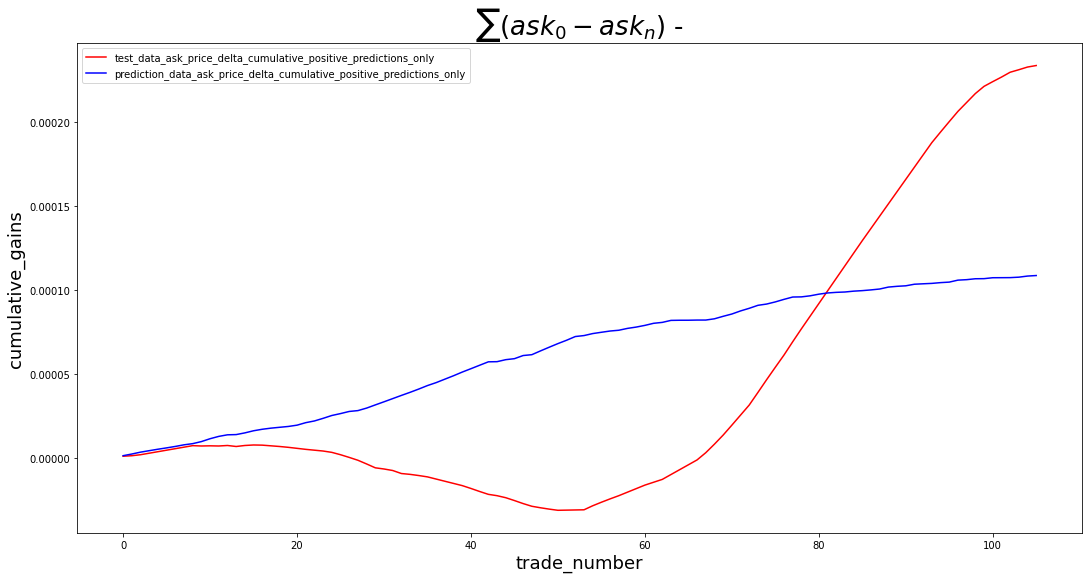

In [ ]:
plt.figure(figsize = (18,9))
plt.plot(test_data_ask_price_delta_cumulative_positive_predictions_only, color = 'red', label='test_data_ask_price_delta_cumulative_positive_predictions_only')
plt.plot(prediction_data_ask_price_delta_cumulative_positive_predictions_only, color = 'blue', label = 'prediction_data_ask_price_delta_cumulative_positive_predictions_only')
plt.title(r'$\sum (ask_0 - ask_n$) - ', fontsize=26)
plt.xlabel('trade_number', fontsize=18)
plt.ylabel('cumulative_gains', fontsize=18)
plt.legend()
plt.show()

Anyone that has ever bought BTC or any financial instrument on an exchange would now tell me you can’t actually sell at market at the ask price. The bid/ask spread would stop us from taking advantage of any increase in price, and only if the appreciation of the asset was higher than the spread would we be able to profit from this trade.
Once we model this into our prediction our golden goose starts to lose a few feathers. Our same 100 dollars would still appreciate by ~$3.40! Still an impressive 1,318% annual return.

In [ ]:
test_data_ask_vs_bid_price_delta_positive_predictions_only = []
prediction_data_ask_vs_bid_price_delta_positive_predictions_only = []

for i, p in enumerate(predictions):
    delta = p[:,3][n_future_preds-1]-p[:,0][0]
    if delta > 0:
        buy = y_test["ask_price"][i+steps]
        sale = y_test["bid_price"][i]
        test_data_ask_vs_bid_price_delta_positive_predictions_only.append(sale-buy)
        prediction_data_ask_vs_bid_price_delta_positive_predictions_only.append(delta)

test_data_ask__vs_bid_price_delta_cumulative_positive_predictions_only = np.cumsum(test_data_ask_vs_bid_price_delta_positive_predictions_only)
prediction_data_ask_vs_bid_price_delta_cumulative_positive_predictions_only = np.cumsum(prediction_data_ask_vs_bid_price_delta_positive_predictions_only)

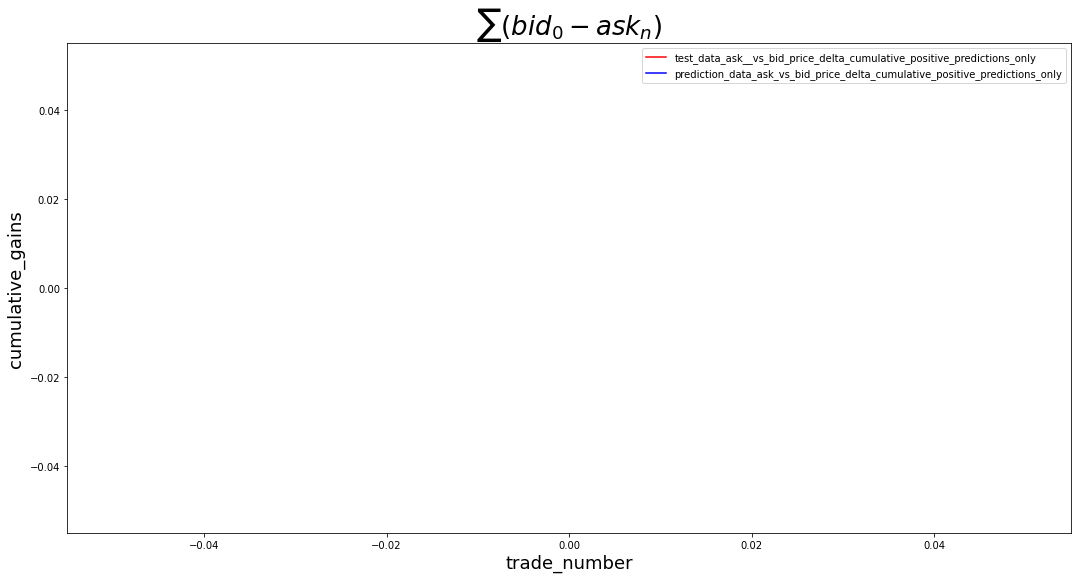

In [ ]:
plt.figure(figsize = (18,9))
plt.plot(test_data_ask__vs_bid_price_delta_cumulative_positive_predictions_only, color = 'red', label='test_data_ask__vs_bid_price_delta_cumulative_positive_predictions_only')
plt.plot(prediction_data_ask_vs_bid_price_delta_cumulative_positive_predictions_only, color = 'blue', label = 'prediction_data_ask_vs_bid_price_delta_cumulative_positive_predictions_only')
plt.title(r'$\sum (bid_0 - ask_n$)', fontsize=26)
plt.xlabel('trade_number', fontsize=18)
plt.ylabel('cumulative_gains', fontsize=18)
plt.legend()
plt.show()

Now let’s add in transaction costs. We’ll take the liberal assumption that we can trade at market for the low fee of just 0.1% — reserved for traders trading at extremely large volumes.
It quickly becomes apparent our golden goose is not gold at all. Our model is only able to identify 3 potential profitable trades, of our same 100 dollars would now turn a $2.26 loss.


In [ ]:
test_data_ask_vs_bid_price_plus_txfee_delta_positive_predictions_only = []
prediction_data_ask_vs_bid_price_plus_txfee_delta_positive_predictions_only = []
taker_fee = 0.001

for i, p in enumerate(predictions):
    buy_predict = p[:,0][0]*(1+taker_fee)
    sell_predict = p[:,3][n_future_preds-1]*(1-taker_fee)
    delta = sell_predict - buy_predict
    if delta > 0:
        buy = y_test["ask_price"][i+steps]*(1+taker_fee)
        sale = y_test["bid_price"][i]*(1-taker_fee)
        test_data_ask_vs_bid_price_plus_txfee_delta_positive_predictions_only.append(sale-buy)
        prediction_data_ask_vs_bid_price_plus_txfee_delta_positive_predictions_only.append(delta)

test_data_ask_vs_bid_price_plus_txfee_delta_positive_predictions_only = np.cumsum(test_data_ask_vs_bid_price_plus_txfee_delta_positive_predictions_only)
prediction_data_ask_vs_bid_price_plus_txfee_delta_positive_predictions_only = np.cumsum(prediction_data_ask_vs_bid_price_plus_txfee_delta_positive_predictions_only)
        

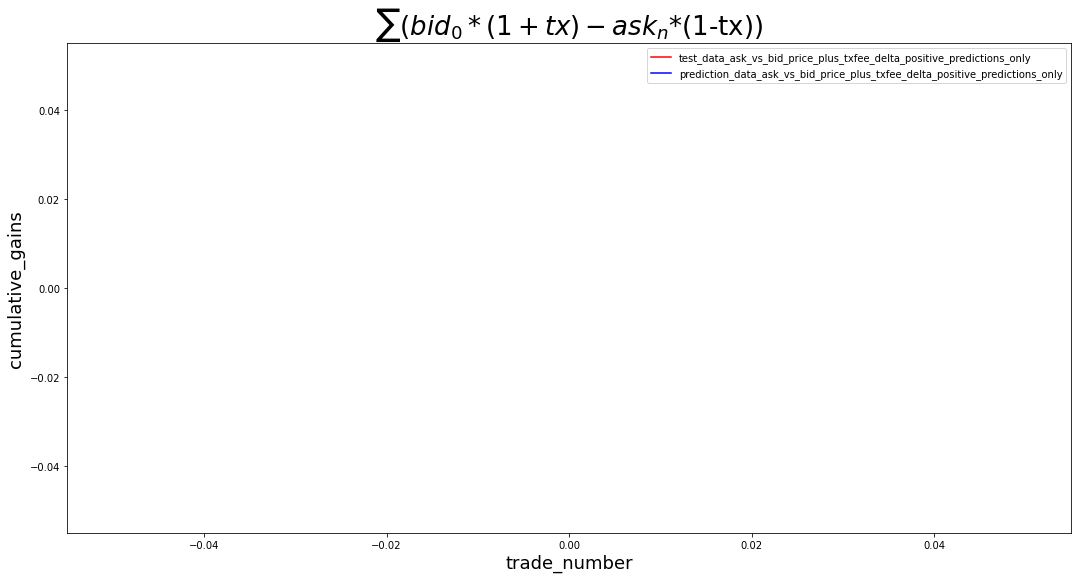

In [ ]:
plt.figure(figsize = (18,9))
plt.plot(test_data_ask_vs_bid_price_plus_txfee_delta_positive_predictions_only, color = 'red', label='test_data_ask_vs_bid_price_plus_txfee_delta_positive_predictions_only')
plt.plot(prediction_data_ask_vs_bid_price_plus_txfee_delta_positive_predictions_only, color = 'blue', label = 'prediction_data_ask_vs_bid_price_plus_txfee_delta_positive_predictions_only')
plt.title(r'$\sum (bid_0*(1+tx) - ask_n$*(1-tx))', fontsize=26)
plt.xlabel('trade_number', fontsize=18)
plt.ylabel('cumulative_gains', fontsize=18)
plt.legend()
plt.show()

The project above shows that simple financial data has some predictive power in forecasting short-term changes in price, but as there are no practical opportunities to profit from this information this particular model is relatively useless from a trading perspective.
Tools such as the LSTM model and others are becoming more accessible every day, with large groups and institutions pushing the boundaries of what these models can do through better data and superior processing capacity. This leads to markets integrating ever increasing amounts of information into asset prices — making arbitrage opportunities rare.
